# 4. MLP応用
## 概要
本演習ではChapter04で学習した、深層学習の基礎である多層パーセプトロン(応用)を穴埋め形式で実装します。<br>
予め用意されたコードはそのまま使用し、指示された穴埋め部を編集してください。
演習問題文は<font color="Red">赤字</font>で表示されています。<br>
また、乱数設定により実行結果が異なるため、<font color="Red">コードを完成させたあと、必ずもう一度一番上のセルから順に最後まで実行して結果を確認してください。</font>

所要時間：4~8時間
> dataset
>> **正則化**: MNIST<br>
>> **データ拡張**: rabbit.jpg<br>

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [1]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール
    !pip install tensorflow==2.8.0 tensorflow_addons==0.16.1
else:
    print("Not Google Colab")

Not Google Colab


### 【Google colabのみ実行】ドライブのマウント

Google Colabでは、**マウント**という作業を行って、Googleドライブ内のファイルを操作できる状態にする必要があります。<br>
<br>
以下のコードを実行してマウントしてください。なお、認証で**Googleアカウントへのログインが必要**になります。

In [2]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not Google Colab")

Not Google Colab


### ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [38]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import os
import sys
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.python.ops.gen_array_ops import one_hot

### データの読み込み


In [39]:
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()

In [40]:
print("X_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("X_test : ", x_test.shape)
print("y_test : ", y_test.shape)

X_train :  (60000, 28, 28)
y_train :  (60000,)
X_test :  (10000, 28, 28)
y_test :  (10000,)


## 正則化（TensorFlow）

### ドロップアウト
ドロップアウトとは、学習時に指定された割合のノードをランダムに消すテクニックであり、部分的なネットワークのアンサンブル学習として捉えることができます。これによって、表現力が高いMLPにおいても過学習を抑制することが可能になる場合あります。




TensorflowでDropoutを実装する場合は`tf.keras.layers.Dropout()`が用いられます。

* <font color="Red">問1. TensorflowでDropoutを実装しましょう。</font>
  * <font color="Red">問1-1. 確率 `0.5` で出力を0にするDropoutのインスタンスを生成しましょう。</font>
  * <font color="Red">問1-2. 入力`input` に対しDropoutを適用する処理を記述しましょう。</font>

In [41]:
gen = tf.random.Generator.from_seed(1)
input = gen.normal(shape=[3, 4])
print('入力: \n',input)

layer = tf.keras.layers.Dropout(0.5)   ### 問1-1 ###
output = layer(input, training=True) ### 問1-2 ###
print('Dropout後の出力: \n', output)

入力: 
 tf.Tensor(
[[ 0.43842274 -0.53439844 -0.07710262  1.5658046 ]
 [-0.1012345  -0.2744976   1.4204658   1.2609464 ]
 [-0.43640924 -1.9633987  -0.06452483 -1.056841  ]], shape=(3, 4), dtype=float32)
Dropout後の出力: 
 tf.Tensor(
[[ 0.         -1.0687969  -0.          3.1316092 ]
 [-0.202469   -0.5489952   2.8409317   2.5218928 ]
 [-0.         -0.         -0.12904966 -2.113682  ]], shape=(3, 4), dtype=float32)


### パラメータノルムペナルティ

ノルムペナルティとは、モデルのパラメータが学習時に極端な値を取らないよう制限をかける手法です。

下記の式のように、損失関数にパラメータのLpノルム$||w||_{p}$を加えます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \lambda||w||_{p}
$$

まずはLpノルム$||w||_{p}$を算出する関数を実装しましょう。また、以下ではテンソルに対するnumpyを用いた演算はエラーが生じる可能性がありますのでtensorflowを用いた演算を使いましょう。

* <font color="Red">問2. Lpノルムを算出する関数を完成させてください。</font>

In [42]:
def lp_norm(w, p=2):
  return  tf.norm(w, ord=p)### 問2 ###

次に、ラッソの損失を算出する関数を実装しましょう。

ラッソの損失はL1ノルムを用いて、下記の式のように定義されます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \lambda\sum_{n=1}^D{|{w_n}|}
$$

コード内の```parameters```は```{{1層目のパラメータ},{2層目のパラメータ},...,{最終層のパラメータ}}```のようにパラメータが入れ子リストの構造になっています。

* <font color="Red">問3. L1ノルム付き損失関数の$\lambda\sum_{n=1}^D{|w_n|}$を算出する関数を完成させてください。</font>

In [43]:
def Lasso_loss(net, lam=0.001):
  loss = 0
  parameters = net.get_weights()
  for params in parameters:
    loss += tf.reduce_sum(tf.abs(params))### 問3 ###
  return lam * loss

次に、リッジの損失を算出する関数を実装しましょう。

L2ノルム付き損失関数はL2ノルムを用いて、下記の式のように定義されます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \frac{\lambda}{2}{\sum_{n=1}^D{w_n^2}}
$$

コード内の```parameters```は```{{1層目のパラメータ},{2層目のパラメータ},...,{最終層のパラメータ}}```のようにパラメータが入れ子リストの構造になっています。


* <font color="Red">問4.  L2ノルム付き損失関数の$\frac{\lambda}{2}{\sum_{n=1}^D{w_n^2}}$を算出する関数を完成させてください。</font>

In [44]:
def Ridge_loss(net, lam=0.001):
  loss = 0
  parameters = net.get_weights()
  for params in parameters:
    loss += tf.reduce_sum(tf.square(params))### 問4 ###
  return (1/2) * lam * loss

## ドロップアウトとL2ノルム正則化を含めたMLPの実装 (<u>ライブラリを使用しない</u>)

ドロップアウトを含めたMLPクラスを実装します。<br>
今回構築するモデルのアーキテクチャは以下のようになっています。<br>

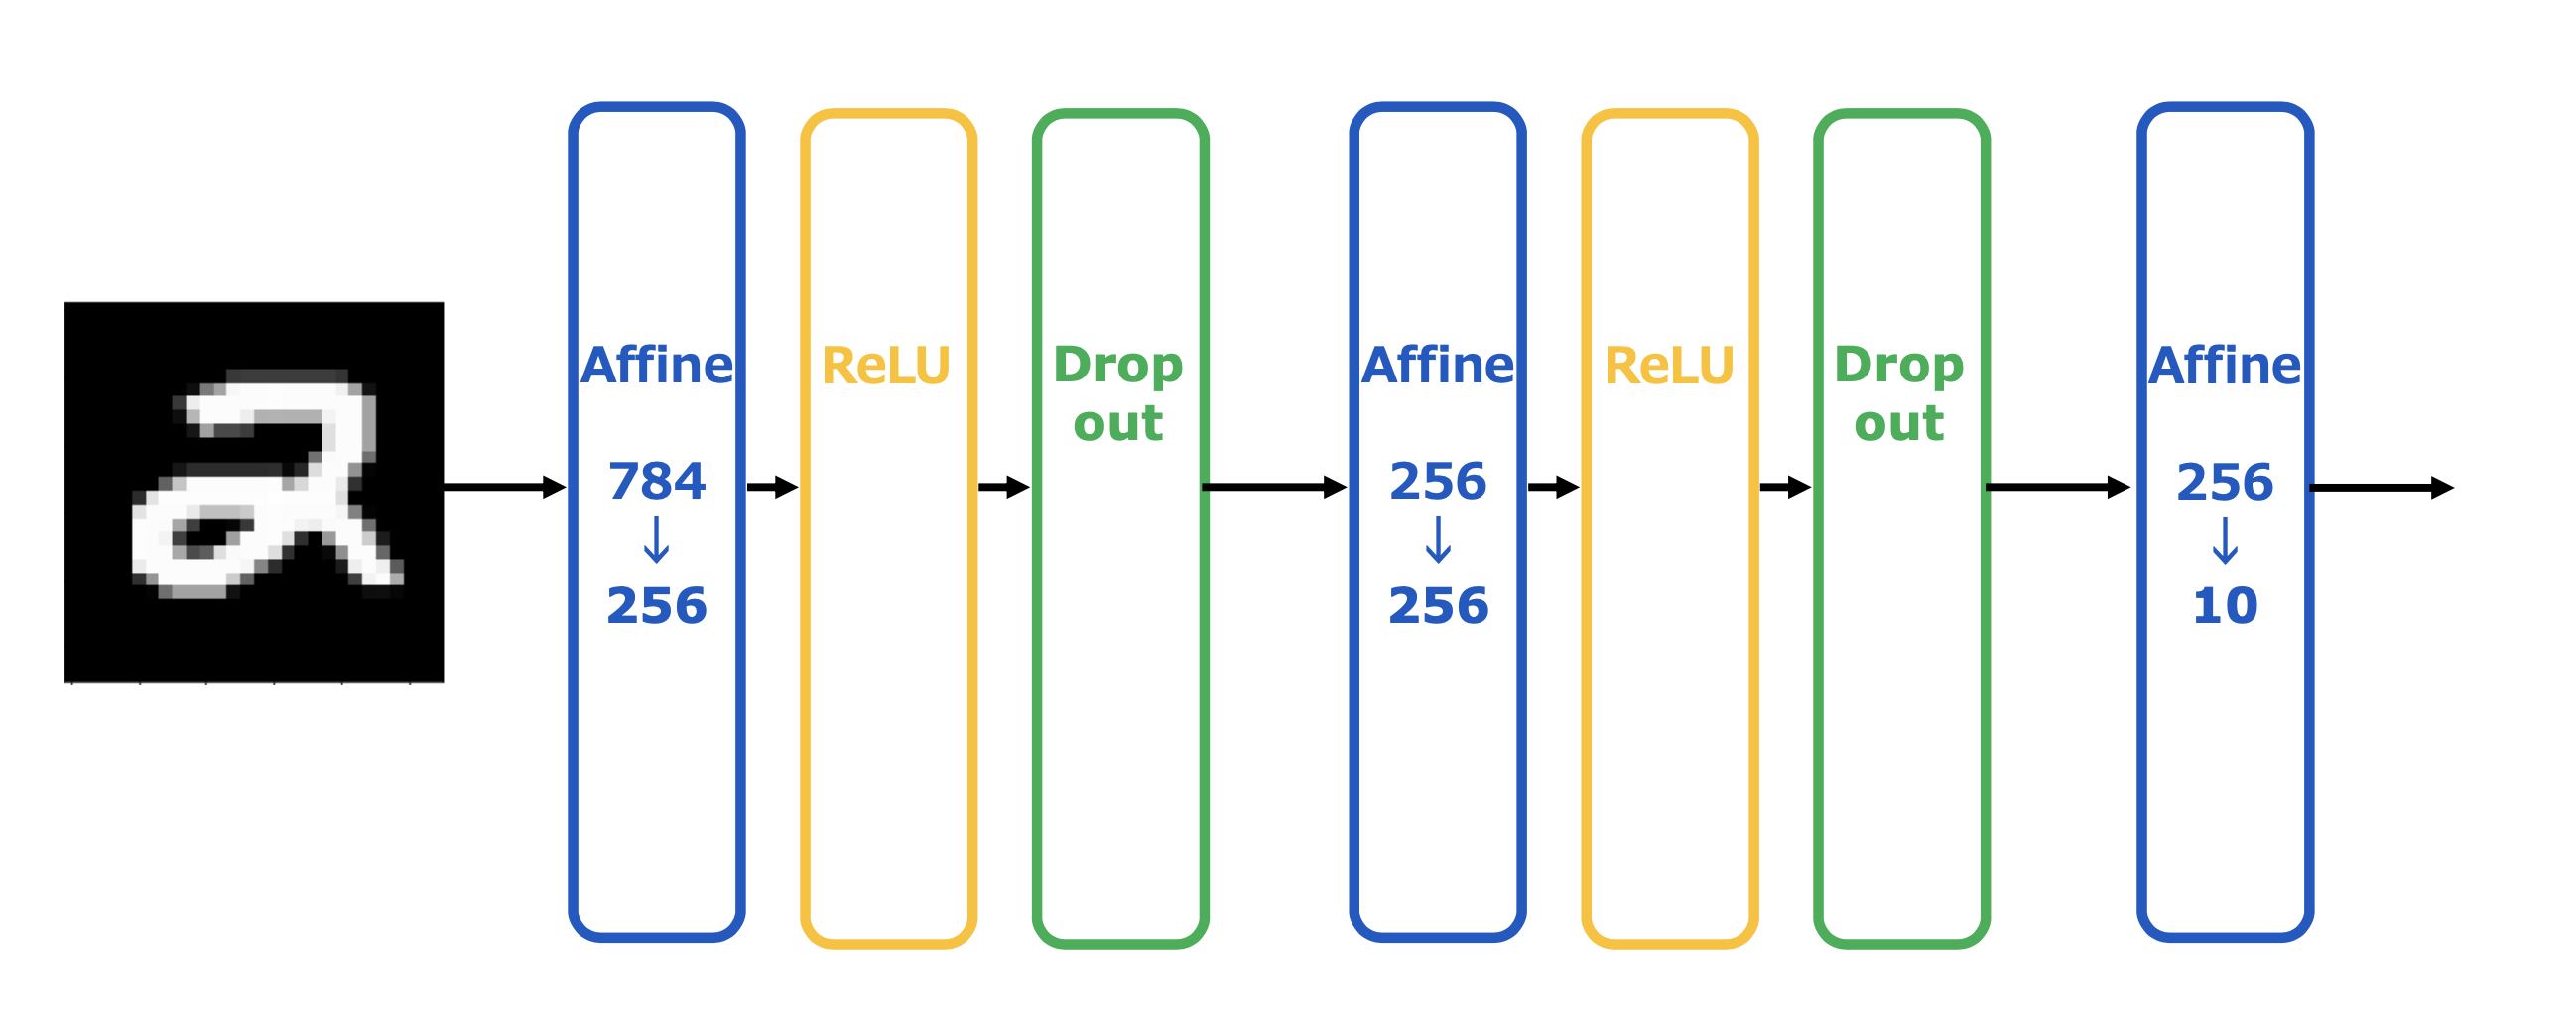

* <font color="Red">問5.ドロップアウトを含めたMLPクラスを完成させてください。</font><br>
    * <font color="Red">問5-1. 正則化を加えたDenseレイヤーを記述しましょう。ここでkernel_regularizerからL2ノルム正則化を指定してください。
    
    その際、ラムダは0.001に指定してください。</font><br>
    * <font color="Red">問5-2. Dropoutレイヤーを記述しましょう。その際、20%の確率でドロップアウトを行うよう指定してください。</font><br>

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(256,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),### 問5-1 ###,
    tf.keras.layers.Dropout(0.2), ### 問5-2 ###,
    tf.keras.layers.Dense(256,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),### 問5-1 ###,
    tf.keras.layers.Dropout(0.2), ### 問5-2 ###,
    tf.keras.layers.Dense(10,activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-tr

```python
#keras functionalAPIでの実装
inputs = tf.keras.layers.Input(shape=(28,28))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=predictions)
```

### 学習
始めに、モデルや損失関数、最適化アルゴリズムを定義します。

* <font color="Red">問6. 損失関数はスクラッチの場合、問4で実装した`Ridge_loss`を使用して、損失関数に正則化項$\frac{\lambda}{2}{\sum_{n=1}^D{w_n^2}}$を加えて定義する。穴埋めで完成させましょう。</font>

In [46]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy()

def compute_loss(t,y,criterion=criterion):

  loss =  criterion + Ridge_loss(model, lam=0.001) ### 問6 ###
  return loss

model.compile(optimizer='adam',
               loss=criterion,
               metrics=['accuracy']
               )

最後に学習ステップ`train_step`、テストステップ`test_step`を用いて学習と評価を行います。

accuracyが95%前後になっていれば学習成功です。

In [47]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint(
                 '../mnist_sequential_{epoch:03d}_{val_loss:.4f}.h5',
                 save_best_only=True
             )]

history = model.fit(x_train, y_train, batch_size=100, epochs=15,
                    validation_split=0.2,callbacks=callbacks)

Epoch 1/15
480/480 [==============================] - 2s 4ms/step - loss: 4.4800 - accuracy: 0.7999 - val_loss: 0.9968 - val_accuracy: 0.9119
Epoch 2/15
480/480 [==============================] - 2s 3ms/step - loss: 1.1903 - accuracy: 0.8711 - val_loss: 0.8536 - val_accuracy: 0.9231
Epoch 3/15
480/480 [==============================] - 2s 3ms/step - loss: 0.9246 - accuracy: 0.9006 - val_loss: 0.7120 - val_accuracy: 0.9374
Epoch 4/15
480/480 [==============================] - 2s 3ms/step - loss: 0.7755 - accuracy: 0.9178 - val_loss: 0.6584 - val_accuracy: 0.9438
Epoch 5/15
480/480 [==============================] - 2s 3ms/step - loss: 0.6724 - accuracy: 0.9322 - val_loss: 0.5786 - val_accuracy: 0.9498
Epoch 6/15
480/480 [==============================] - 2s 3ms/step - loss: 0.5919 - accuracy: 0.9419 - val_loss: 0.5211 - val_accuracy: 0.9538
Epoch 7/15
480/480 [==============================] - 2s 3ms/step - loss: 0.5292 - accuracy: 0.9472 - val_loss: 0.4773 - val_accuracy: 0.9577
Epoch 

## データ拡張（Tensorflow）

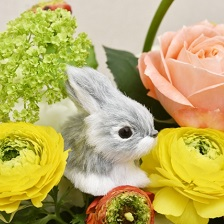

In [48]:
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マイドライブ内のデータを読み込むpathに設定
    img_path = '/content/drive/MyDrive/rabbit.jpg'
else:
    img_path = 'rabbit.jpg'

# rabbit.jpg を読み込み表示する
img = Image.open(img_path)
display(img)

### flip

flipは画像を反転させるデータ拡張方法です。ここでは、`random_flip_left_right`と`random_flip_up_down`を用いて実装します。

`random_flip_left_right`は水平方向に確率`0.5`に従って反転します。

`random_flip_up_down`は垂直方向に確率`0.5`に従って反転します。


分かりやすさのため、ここではseed値を指定して必ず反転した画像を出力します。

`tf.random.set_seed`でseed値を0に固定することで必ず反転させることができます。
* <font color="Red">問7-1. `tf.image.random_flip_left_right`を用いて、水平方向に反転させるデータ拡張を加えてください。</font>
* <font color="Red">問7-2. `tf.image.random_flip_up_down`を用いて、垂直方向に反転させるデータ拡張を加えてください。</font>

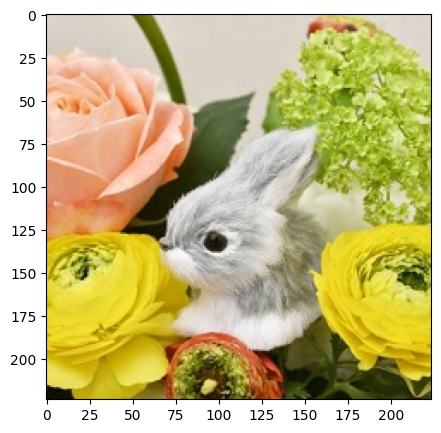

In [49]:
#画像を読み込む
img = Image.open(img_path)
img = np.array(img)
plt.figure(figsize=(5,5))

#画像データ生成器の作成
tf.random.set_seed(0)
img = tf.image.random_flip_left_right(img)### 問7-1 ###

plt.imshow(img)
plt.show()


(224, 224, 3)


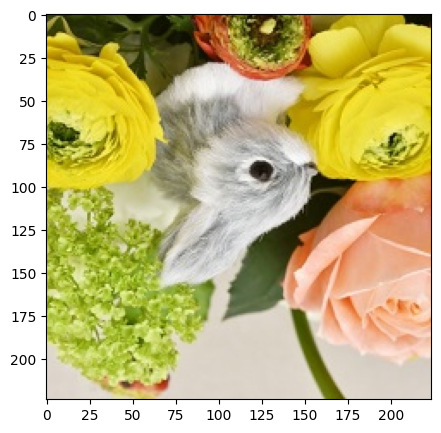

In [50]:
#画像を読み込む
img = Image.open(img_path)
img = np.array(img)
plt.figure(figsize=(5,5))

print(img.shape)

#画像データ生成器の作成
tf.random.set_seed(0)
img = tf.image.random_flip_up_down(img)### 問7-2 ###

plt.imshow(img)
plt.show()


### cutout

`cutout`は、画像の中の長方形領域をランダムに選択しそのピクセルを消去するデータ拡張方法です。

`tensorflow_addons.image`(以降`tfa.image`)に実装されている関数、`random_cutout`は以下のような引数を持ちます。

```
【引数】
  mask_size : 塗りつぶす短形のサイズについてのパラメータ。元画像からの比率を[H,W]としてfloatで指定する。mask_sizeは2で割り切れる必要がある。
  constant_values : 塗りつぶす色についてのパラメータ。0.0～1.0の画像の場合はconstant_values=0.5で灰色となる。 デフォルト値は0のため黒で塗りつぶされる。
```


* <font color="Red">問8. `tfa.image.random_cutout`を用いて、画像内の長方形領域をランダムにピクセル消去させるデータ拡張を加えてください。ただし、以下の条件を満たしてください。</font>
  * <font color="Red">入力画像に対する消去領域の比率の範囲を(0.02, 0.33)とします。</font>
  * <font color="Red">消去領域のアスペクト比の範囲を(0.3, 3.3)とします。</font>
  * <font color="Red">消去領域の色は黒(=0)とします。</font>

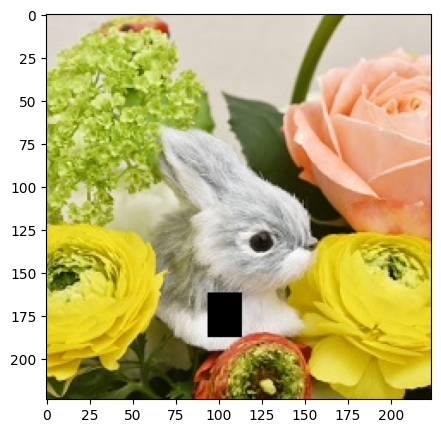

In [51]:
#画像を読み込む
img = Image.open(img_path)
img = np.array(img).astype(int)
plt.figure(figsize=(5,5))

#画像データ生成器の作成
img = img[np.newaxis,:]

img_shape = img.shape[-3:]

h_ratio = random.random()*0.31+0.02
w_ratio = (random.random()*3.0+0.3)*h_ratio

mask_size = (int(img_shape[0]*h_ratio/2)*2,int(img_shape[1]*w_ratio/2)*2)

img = tfa.image.random_cutout(img, mask_size=mask_size, constant_values=0)### 問8 ###

plt.imshow(img[0])
plt.show()


### crop

`crop`は画像の切り取りによって得られるデータ拡張方法です。ここではtf.imageに実装されている、`random_crop`を利用します。

`random_crop`は以下のような引数を持ちます。

```
【引数】
  size : 切り取るサイズ
```

* <font color="Red">問9. `tensorflow.image.random_crop`を用いて、元画像の(140, 140)のサイズを切り取るデータ拡張を加えてください。</font>

(224, 224, 3)


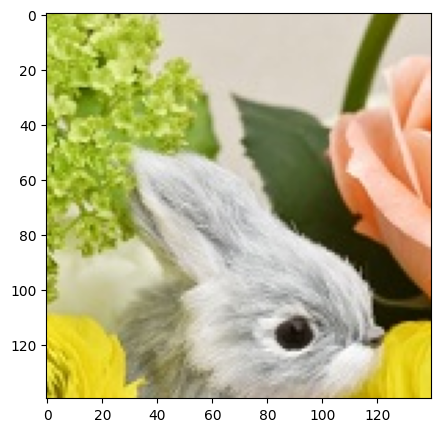

In [52]:
#画像を読み込む
img = Image.open(img_path)
img = np.array(img).astype(int)
plt.figure(figsize=(5,5))

print(img.shape)

#画像データ生成器の作成
img = tf.image.random_crop(img, [140, 140, img.shape[-1]])### 問9 ###

plt.imshow(img)
plt.show()


### Brightness

データ拡張の一つに、画像の明るさを変更させる手法があります。ここでは画像の明るさ、コントラスト、彩度、色合いをランダムに変化させます。<br>

それぞれtf.imageに実装されている関数を利用しデータ拡張を行います。

`random_brightness`は以下のような引数を持ちます。

```
【引数】
  max_delta : ランダムで選択される明るさの範囲。
              [-max_delta, max_delta)で選択される。正である必要がある。
```

`random_contrast`は以下のような引数を持ちます。

```
【引数】
  lower,uppes : ランダムで選択されるコントラストの範囲。
              [lower, upper)で選択される。lowerは正である必要がある。
```

`random_saturation`は以下のような引数を持ちます。

```
【引数】
  lower,uppes : ランダムで選択される彩度の範囲。
              [lower, upper)で選択される。lowerは正である必要がある。
```

`random_hue`は以下のような引数を持ちます。

```
【引数】
  max_delta : ランダムで選択される色合いの範囲。
              [-max_delta, max_delta)で選択される。
```

* <font color="Red">問10. tf.imageに実装されている関数を用いて、画像の明るさを変更させるデータ拡張を加えましょう。ただし、以下の条件を満たしてください。</font>
  * <font color="Red">明るさの範囲を[-0.25, 0.25)とします</font>
  * <font color="Red">コントラストの範囲を[0.25, 1.8)とします</font>
  * <font color="Red">彩度の範囲を[0.25, 1.8)とします</font>
  * <font color="Red">色合いの範囲を[-0.2, 0.2)とします</font>

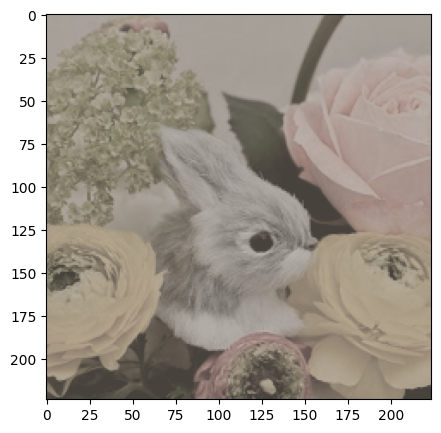

In [53]:
#画像を読み込む
img = Image.open(img_path)
img = np.array(img)
plt.figure(figsize=(5,5))

distorted_img = tf.image.random_brightness(img, 0.25)### 問10 明るさを変更 ###
distorted_img = tf.image.random_contrast(distorted_img, 0.25, 1.8)### 問10 コントラストを変更 ###
distorted_img = tf.image.random_saturation(distorted_img, 0.25, 1.8)### 問10 彩度を変更 ###
distorted_img = tf.image.random_hue(distorted_img, 0.2)### 問10 色合いを変更 ###

plt.imshow(distorted_img)
plt.show()



### Rotate

rotateは画像を回転させることによって得られるデータ拡張方法です。

今回はtfa.imageに実装されている関数で、指定された角度で画像を反時計回りに回転させます。

`rotate`は以下のような引数を持ちます。

```
【引数】
  angels : 画像を回転させるスカラー角度 (ex. degrees=60)
  fill_mode : 回転した画像の外側は、指定されたモードに従って埋められます。
    reflect 画像端のピクセル情報を反転させたもので補完される
    constant ある一定の値で補完される
    wrap 画像に対して繰り返すようなピクセル情報で補完される
    neraest 最も近いピクセル情報で補完される
  fill_value : fill_modeがconstantだった際に利用するパラメータ

デフォルトではfill_mode='constant'のfill_value=0.0で実行される。
```

* <font color="Red">問11. `rotate`を用いて、画像を45度回転させるデータ拡張を加えましょう。回転した画像の外側は黒色(=0)で塗りつぶしてください。</font>

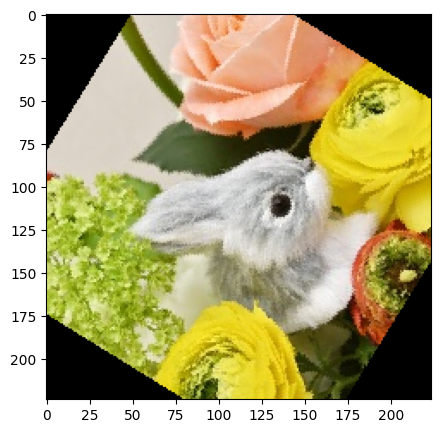

In [54]:
#画像を読み込む
img = Image.open(img_path)
img = np.array(img)
plt.figure(figsize=(5,5))

#画像データ生成器の作成
tf.random.set_seed(0)

img = tfa.image.rotate(img, angles=45, fill_mode='constant', fill_value=0)### 問11 ###

plt.imshow(img)
plt.show()


### MixUp

MixUpは2つの学習サンプルを混合して新たな学習サンプルを作成するデータ拡張手法です。

データとラベルのペア$(X_1, y_1)$と$(X_2, y_2)$から新たな学習サンプル$(X, y)$を作成します。ラベル$y_1, y_2$がone-hot表現の時、以下の式で$(X, y)$を作成します。

$$
X = \lambda X_1 + (1 - \lambda)X_2
$$
$$
y = \lambda y_1 + (1 - \lambda)y_2
$$

ここで、$\lambda$は0~1の範囲を取るパラメータで、ベータ分布$\beta(x,\alpha, \alpha)$からランダムにサンプリングします。$\alpha$はハイパーパラメータです。<br>
ベータ分布は以下のような確率密度関数として表すことができる。$C$は正規化定数。
$$
\beta(x,a,b) = C x ^ {a-1}(1-x) ^ {b-1}(0\leqq x\leqq 1)
$$


* <font color="Red">問12. MixUpにより新たな学習サンプルを作成しましょう。</font>
  * <font color="Red">問12-1. ベータ分布$\beta(\alpha, \alpha)$からサンプリングしましょう。</font>
  * <font color="Red">問12-2. パラメータ`x_l`そして学習サンプル`images_one`、`images_two`を用いて新たな学習データを算出する式を記述してください。</font>

In [55]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

# 評価用のデータセットを作成する
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

BATCH_SIZE=10

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE)
)
# 画像とそれに対応するラベルを混ぜることになるので、
# 同じ学習データからシャッフルした2つのデータセットを結合する。
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))


In [56]:
def sample_beta_distribution(size, concentration_0=1.0, concentration_1=1.0):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=1.0):
    # 画像とラベルに分ける
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # サンプリングとmixupを行うための変形を行う
    l =  sample_beta_distribution(BATCH_SIZE, alpha, alpha)### 問12-1 ###
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # 2つの画像とラベルを組み合わせ、1つの画像とラベルにする
    images = l[:, tf.newaxis, tf.newaxis, tf.newaxis] * images_one + (1 - l[:, tf.newaxis, tf.newaxis, tf.newaxis]) * images_two### 問12-2 ###
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

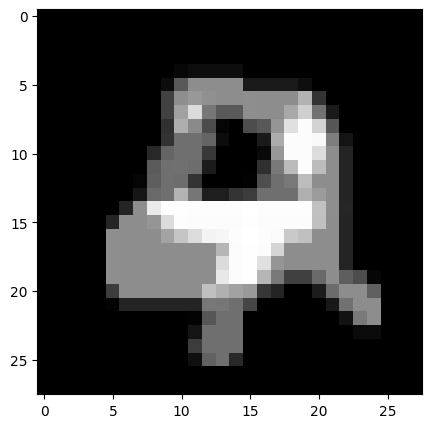

[0.0, 0.0, 0.5623098611831665, 0.0, 0.4376901686191559, 0.0, 0.0, 0.0, 0.0, 0.0]


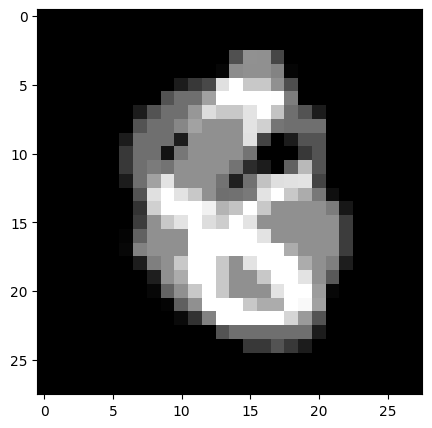

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5656198859214783, 0.0, 0.43438011407852173, 0.0]


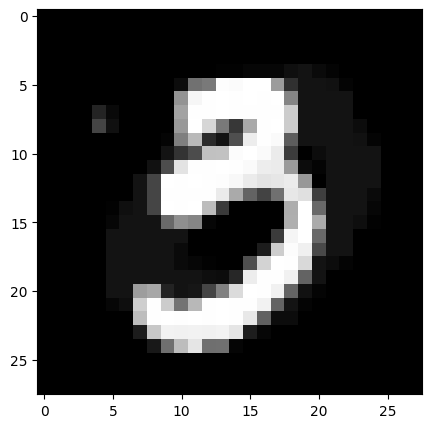

[0.07553082704544067, 0.0, 0.0, 0.9244691729545593, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [57]:
# mixup を用いて新しいデータセットを作成する
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=1.0)
)

# 3枚のサンプルを表示する
sample_images, sample_labels = next(iter(train_ds_mu))
counter = 0
for i, (image, label) in enumerate(zip(sample_images[:3], sample_labels[:3])):
    counter += 1
    plt.figure(figsize=(5, 5))
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.show()
    print(label.numpy().tolist())
    if counter == 3:
        break